In [1]:
%matplotlib inline

In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [3]:
from types import SimpleNamespace

import scipy.constants

###################################################################
# Units
# Length : nm
# Energy : meV
# Current : nA
# Temperature : K

constants = SimpleNamespace(
    hbar=scipy.constants.hbar,
    m_e=scipy.constants.m_e,
    eV=scipy.constants.eV,
    e=scipy.constants.e,
    meV=scipy.constants.eV * 1e-3,
    k_B=scipy.constants.k / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants["Bohr magneton"][0]
    / (scipy.constants.eV * 1e-3),
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,
)

In [4]:
plt.style.use("../../sans_style.mplstyle")
plt.close("all")


pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)
line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]


def add_tl_label(ax, text, color=[1, 1, 1, 0.90]):
    ax.text(
        0.03,
        0.96,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
    )

In [21]:
simname = "Fig5b"

a_label = r"$h_\mathrm{all} / \Delta$"
b_label = r"$\alpha_z$ (meV nm)"

Delta_0 = 0.250
a_scale = Delta_0
b_scale = 1

In [6]:
ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [7]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 2 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [8]:
# Set the temperature
T = 20e-3  # mK

f = -(constants.k_B * T) * logcosh(ws / (2 * constants.k_B * T))
F = np.sum(f, axis=-1)

F.name = "F"

In [9]:
arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

for n in range(len(arm[0])):
    i = arm[0][n]
    j = arm[1][n]
    n = arm[2][n]

    mins_list[i][j].append(theta_ax[n])
    vmins_list[i][j].append(F[i, j, n])

In [10]:
pd = np.zeros((a_N, b_N)) * np.nan
pdm = np.zeros((a_N, b_N)) * np.nan
pdf = np.zeros((a_N, b_N)) * np.nan

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

    if len(mins_list[i][j]) == 1:
        if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
            pd[i][j] = 0
        else:
            pd[i][j] = 3.14

    elif len(mins_list[i][j]) == 2:
        vmmin = np.argmin(vmins_list[i][j])
        mmin = mins_list[i][j][vmmin]

        if abs(mmin) < abs(mmin - np.pi):
            pd[i][j] = 3.14 / 3
        else:
            pd[i][j] = 2 * 3.14 / 3

    else:
        pd[i][j] = np.mean(mins_list[i][j])
    pdm[i][j] = np.mean(mins_list[i][j])
    pdf[i][j] = mins_list[i][j][0]

  0%|          | 0/6561 [00:00<?, ?it/s]

In [11]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j, : theta_N // 2]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

In [12]:
N = F.shape[-1]

ks = rfftfreq(N, 1 / N)
F_k = 2.0 / N * rfft(F)
cF_k = +F_k.real
sF_k = -F_k.imag

In [13]:
a_coord = 50
b_coord = 40

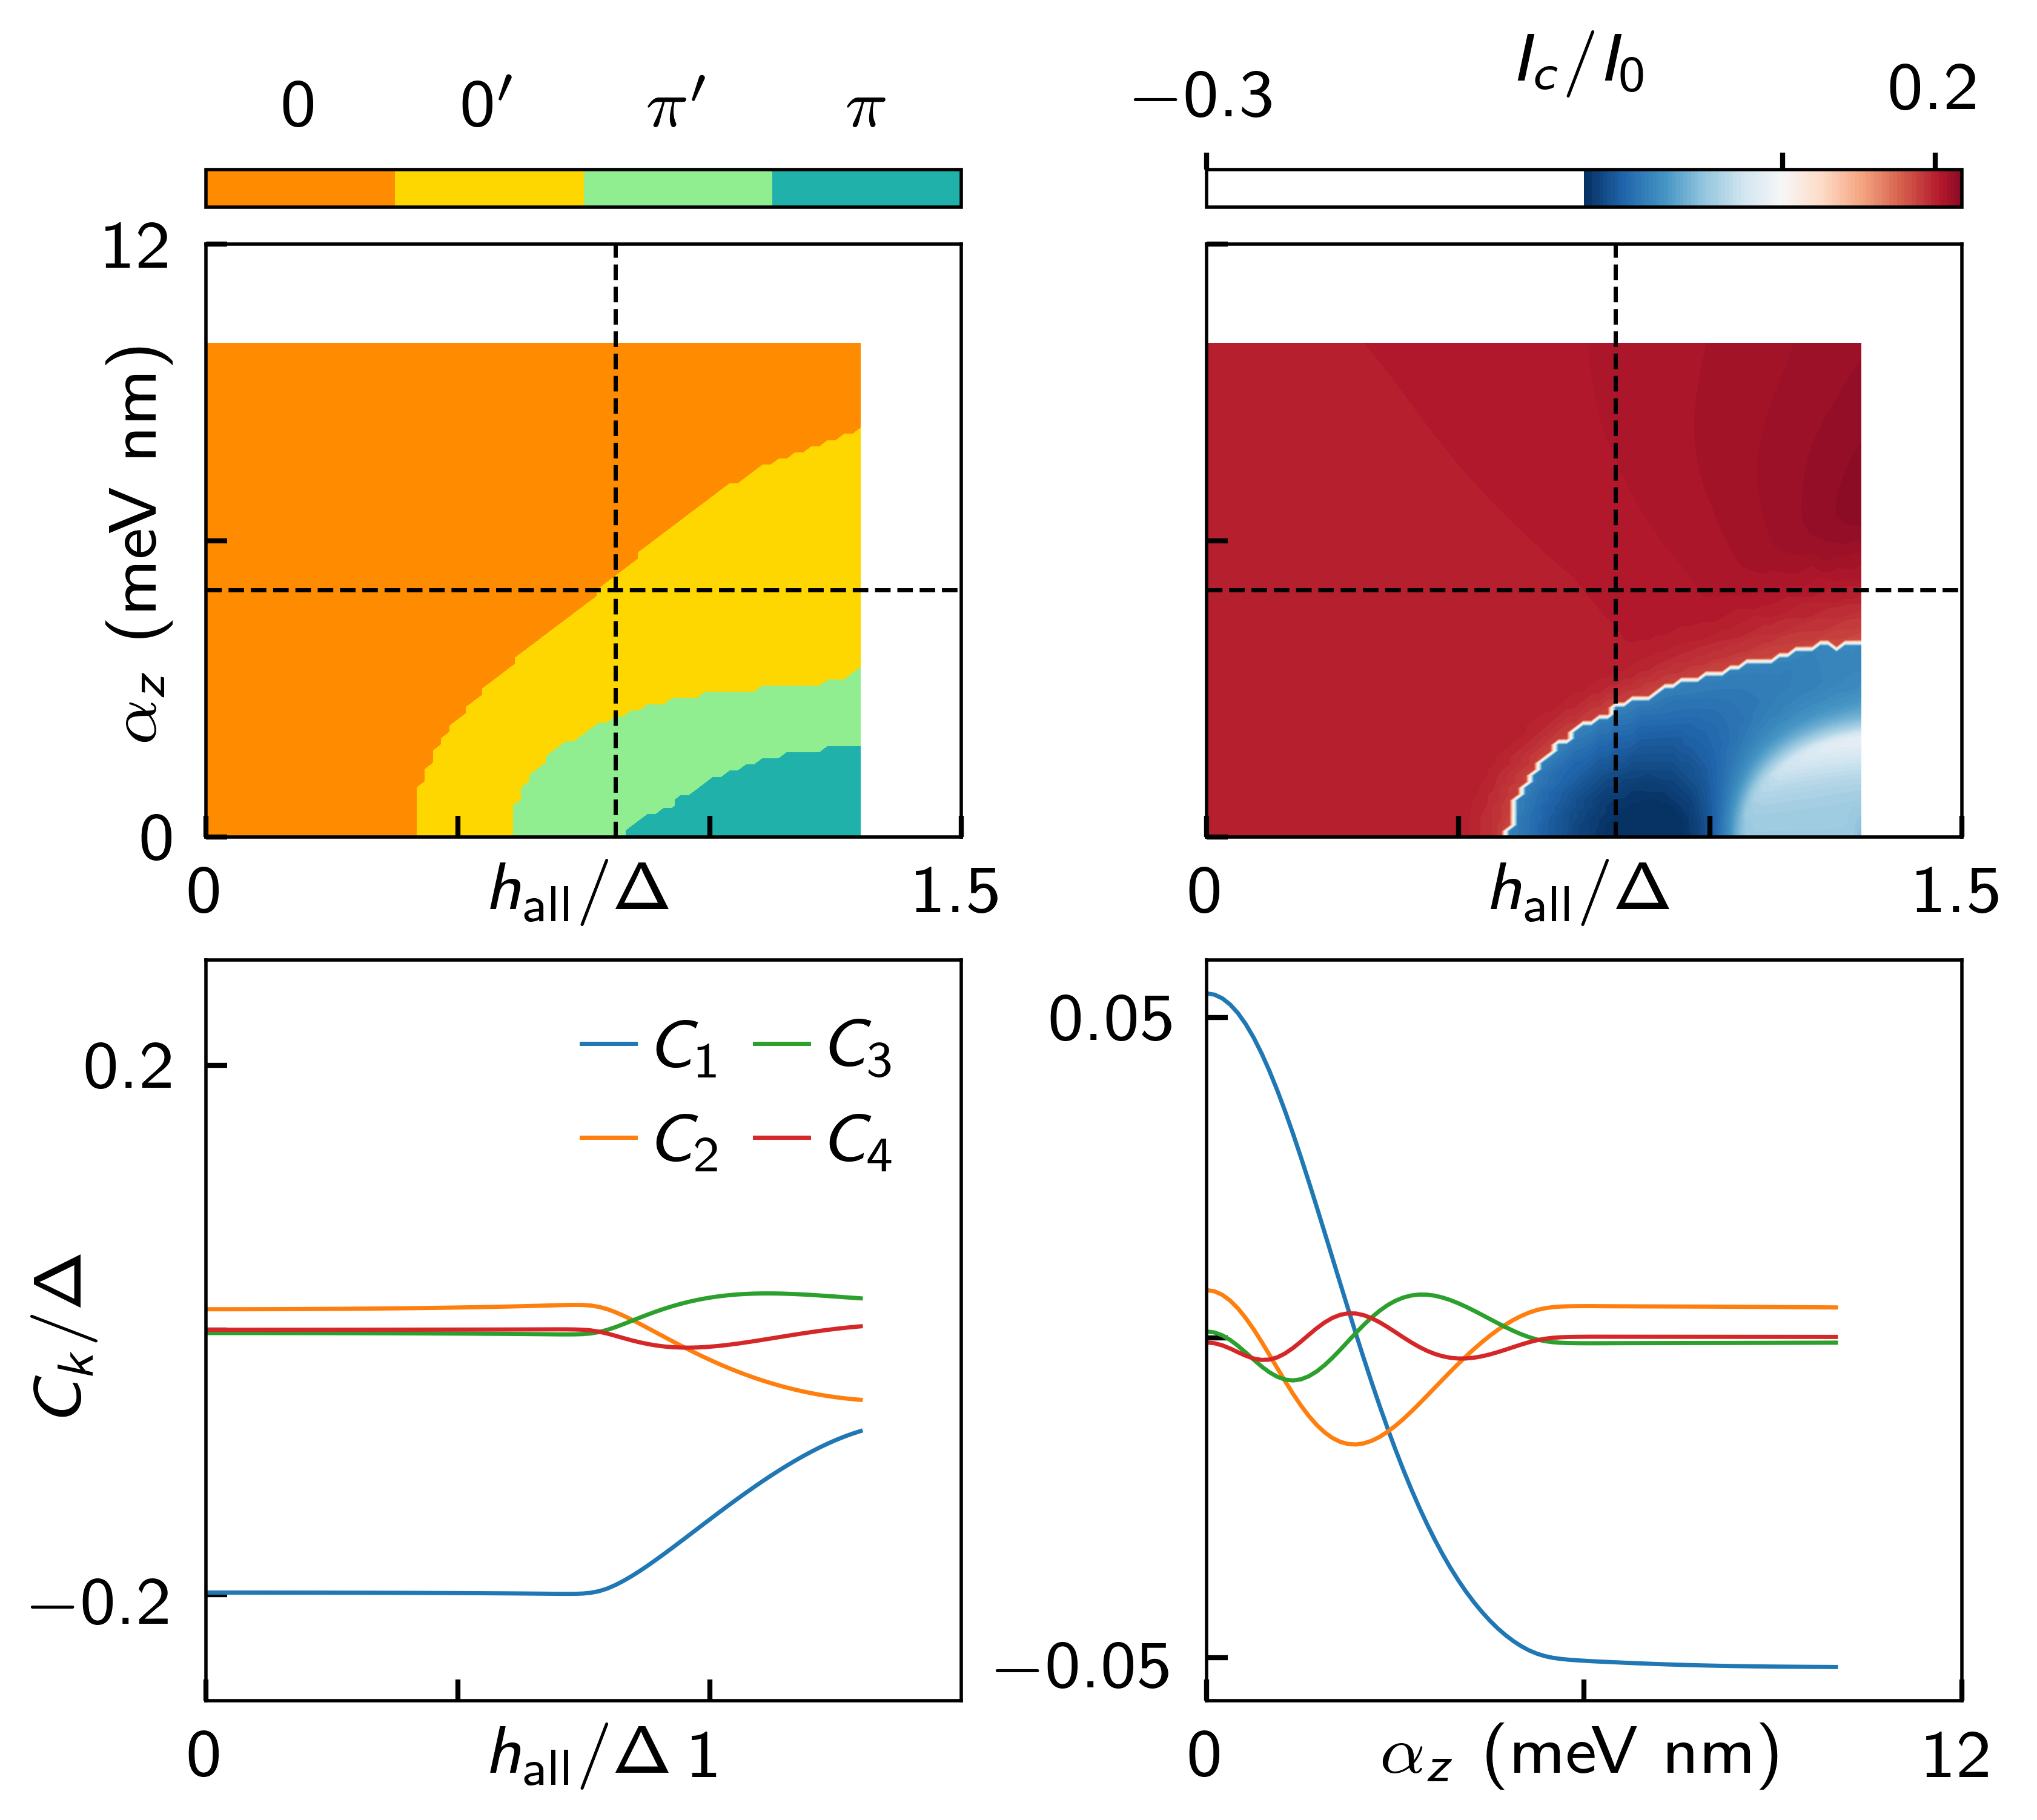

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    dpi=1000, figsize=(3.375, 3.375 * 0.9), ncols=2, nrows=2,
)

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
ax4.set_rasterization_zorder(0)

levels = np.linspace(0, 3.2, 5)

im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

cbar1 = fig.colorbar(im, ax=ax1, location="top")
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0, direction="out")

ax1.set_xlim(0, 1.5)
ax1.set_xticks([0, 0.5, 1, 1.5], labels=[r"$0$", r"", r"", r"$1.5$",])
ax1.set_xlabel(a_label, labelpad=-8)
ax1.set_ylim(0, 12)
ax1.set_yticks([0, 6, 12], labels=[r"$0$", r"", r"$12$"])
ax1.set_ylabel(b_label, labelpad=-8)

ax1.hlines(b_ax[b_coord] / b_scale, 0, 1.5, linestyles="--", colors="k")
ax1.vlines(a_ax[a_coord] / a_scale, 0, 12, linestyles="--", colors="k")


############################################

im = ax2.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)
cbar2 = fig.colorbar(im, ax=ax2, location="top")
cbar2.set_ticks([-0.3, 0, 0.2], labels=[r"$-0.3$", "", r"$0.2$"])
cbar2.set_label(r"$I_c / I_0$", labelpad=-2)
cbar2.ax.tick_params(length=2, direction="out")

ax2.hlines(b_ax[b_coord] / b_scale, 0, 1.5, linestyles="--", colors="k")
ax2.vlines(a_ax[a_coord] / a_scale, 0, 12, linestyles="--", colors="k")

ax2.set_xlim(0, 1.5)
ax2.set_xticks([0, 0.5, 1, 1.5], labels=[r"$0$", r"", r"", r"$1.5$",])
ax2.set_xlabel(a_label, labelpad=-8)
ax2.set_ylim(0, 12)
ax2.set_yticks([0, 6, 12], labels=[])# labels=[r"$0$", r"", r"$12$"])
#ax2.set_ylabel(b_label, labelpad=-8)

# ax2.plot(a_ax / a_scale, I_c[:, b_coord] / I_0, '-')
# ax2.set_xlim(0, 1.5)
# ax2.set_xticks([0, 0.5, 1, 1.5], labels = [r"$0$", r"", r"", r"$1.5$"])
# ax2.set_xlabel(a_label, labelpad=-8)

# ax2.plot(b_ax / b_scale, I_c[a_coord] / I_0, '-')
# ax2.set_xlim(0, 12)
# ax2.set_xticks([0, 6, 12], labels = [r"$0$", r"", r"$12$"])
# ax2.set_xlabel(b_label, labelpad=-8)


############################################

ax3.plot(
    a[:, b_coord] / a_scale, (cF_k[:, b_coord, 1]) / Delta_0, "-", label="$C_1$",
)
ax3.plot(
    a[:, b_coord] / a_scale, (cF_k[:, b_coord, 2]) / Delta_0, "-", label="$C_2$",
)
ax3.plot(
    a[:, b_coord] / a_scale, (cF_k[:, b_coord, 3]) / Delta_0, "-", label="$C_3$",
)
ax3.plot(
    a[:, b_coord] / a_scale, (cF_k[:, b_coord, 4]) / Delta_0, "-", label="$C_4$",
)

ax3.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax3.set_xlabel(a_label, labelpad=-8)
ax3.set_xlim(0, 1.5)

ax3.set_ylabel(r"$C_k / \Delta$", labelpad=-8)
ax3.set_yticks([-0.2, 0, 0.2], labels=[r"$-0.2$", "", r"$0.2$"])
ax3.set_ylim(-0.28, 0.28)

ax3.legend(ncol=2)

############################################

ax4.plot(
    b[0, :] / b_scale, (cF_k[a_coord, :, 1]) / b_scale, "-", label="$C_1$",
)
ax4.plot(
    b[0, :] / b_scale, (cF_k[a_coord, :, 2]) / b_scale, "-", label="$C_2$",
)
ax4.plot(
    b[0, :] / b_scale, (cF_k[a_coord, :, 3]) / b_scale, "-", label="$C_3$",
)
ax4.plot(
    b[0, :] / b_scale, (cF_k[a_coord, :, 4]) / b_scale, "-", label="$C_4$",
)

ax4.set_xticks([0, 6, 12], labels=[r"$0$", r"", r"$12$"])
ax4.set_xlabel(b_label, labelpad=-8)
ax4.set_xlim(0, 12)

#ax4.set_ylabel(r"$C_k / \Delta$", labelpad=-5)
ax4.set_yticks([-0.05, 0.0, 0.05], labels=[r"$-0.05$", "", r"$0.05$"])

############################################


# im3 = ax3.contourf(
#     a / a_scale,
#     b / b_scale,
#     cF_k[:, :, 1] / Delta_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(0),
#     cmap="PuOr_r",
#     zorder=-30,
# )
# cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f")
# cbar3.set_ticks([np.min(cF_k[:, :, 1] / Delta_0), np.max(cF_k[:, :, 1] / Delta_0)])
# cbar3.ax.tick_params(length=0)
# cbar3.set_label(r"$C_1 / \Delta$", labelpad=-15)

# im4 = ax4.contourf(
#     a / a_scale,
#     b / b_scale,
#     cF_k[:, :, 2] / Delta_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(0),
#     cmap="PuOr",
#     zorder=-30,
# )
# cbar4 = fig.colorbar(im4, ax=ax4, format="%3.2f")
# cbar4.set_ticks([np.min(cF_k[:, :, 2] / Delta_0), np.max(cF_k[:, :, 2] / Delta_0)])
# cbar4.ax.tick_params(length=0)
# cbar4.set_label(r"$C_2 / \Delta$", labelpad=-15)


# ax3.set_xticks([0,  1, 2], labels =[r"$0$", r"", r"$2$",])
# ax3.set_yticks([0, 6, 12], labels = [r"$0$", r"", r"$12$",])
# ax3.set_xlabel(a_label, labelpad=-8)
# ax3.set_ylabel(b_label, labelpad=-8)

# ax4.set_xticks([0,  1, 2], labels =[r"$0$", r"", r"$2$",])
# ax4.set_yticks([0, 6, 12], labels = [])
# ax4.set_xlabel(a_label, labelpad=-8)
# #ax4.set_ylabel(b_label, labelpad=-8)

# ax3.hlines(b_ax[b_coord] /b_scale, a_ax.min()/a_scale, a_ax.max()/a_scale, colors='k', linestyles='--')
# ax4.hlines(b_ax[b_coord] /b_scale, a_ax.min()/a_scale, a_ax.max()/a_scale, colors='k', linestyles='--')
# ax3.vlines(a_ax[a_coord] /a_scale, b_ax.min()/b_scale, b_ax.max()/b_scale, colors='k', linestyles='--')
# ax4.vlines(a_ax[a_coord] /a_scale, b_ax.min()/b_scale, b_ax.max()/b_scale, colors='k', linestyles='--')

fig.tight_layout(pad=0.5)

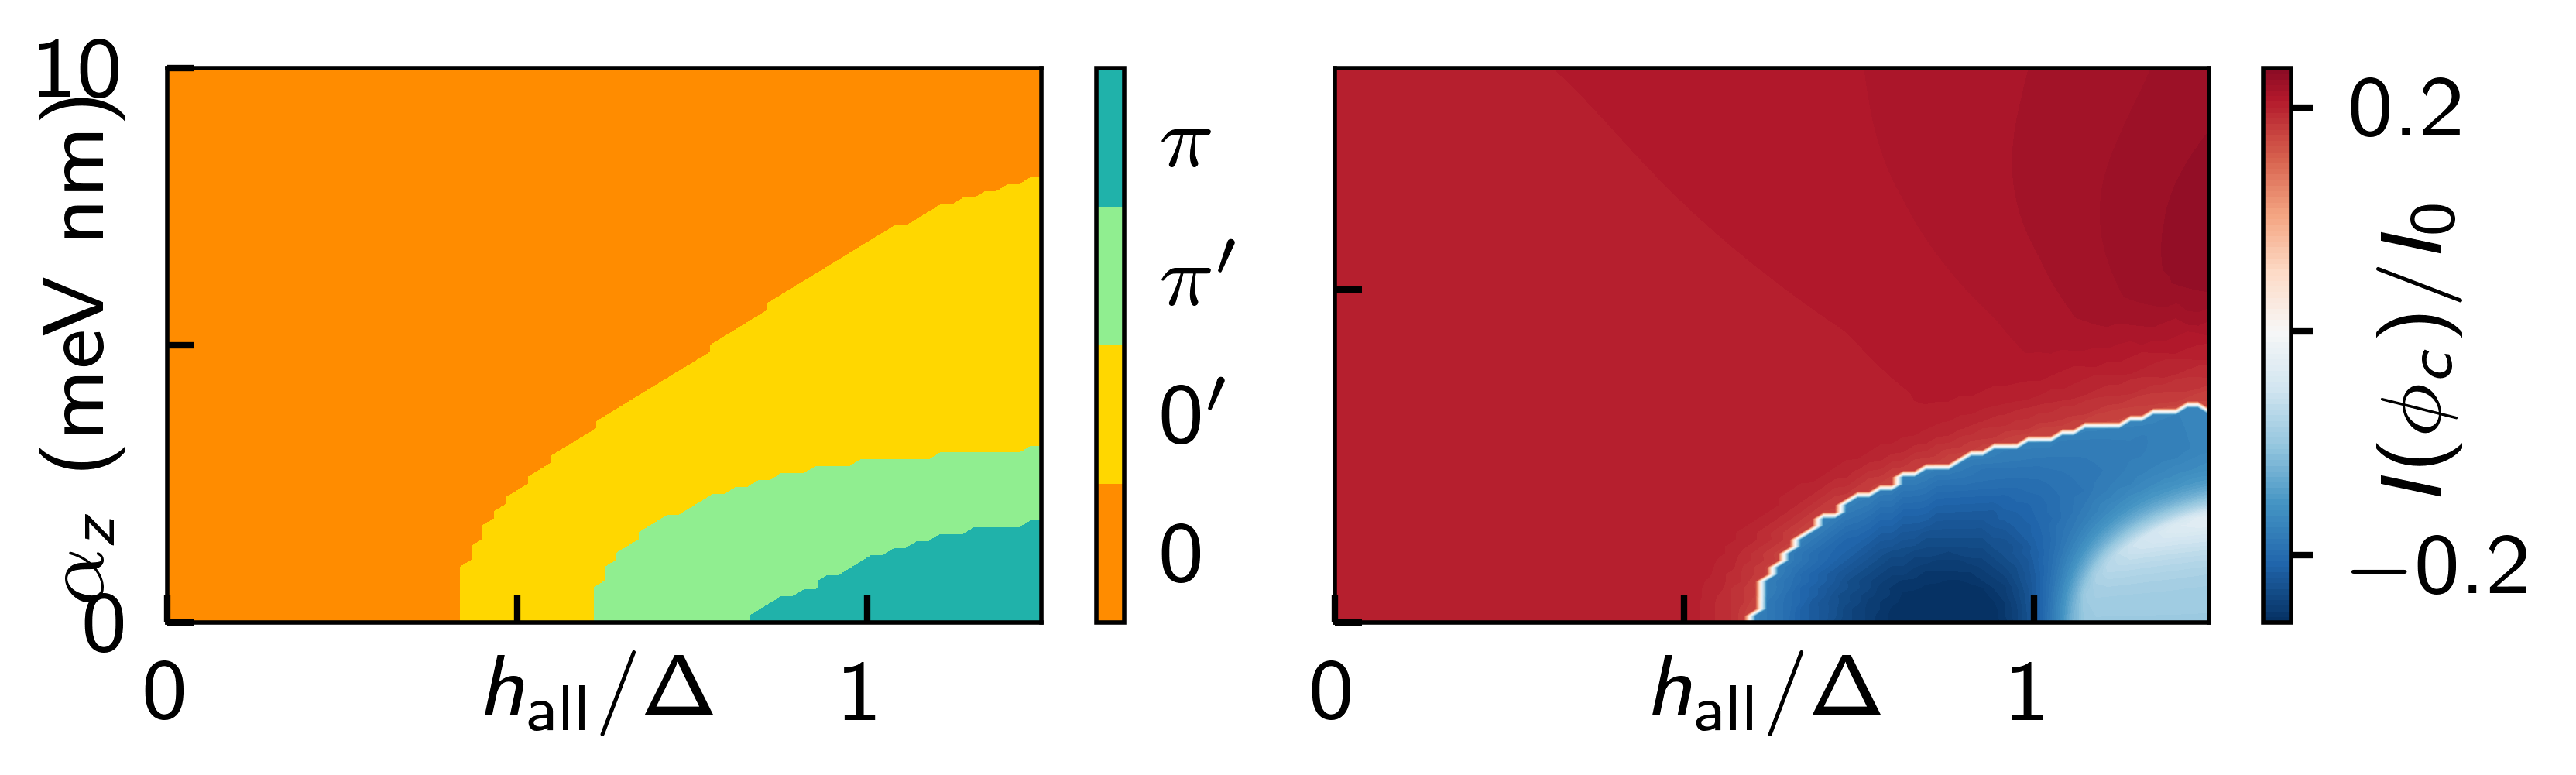

In [22]:
fig, (ax1, ax2) = plt.subplots(dpi=1000, figsize=(3.375, 3.375 * 0.3), ncols=2, nrows=1)

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)

levels = np.linspace(0, 3.2, 5)

im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

cbar1 = fig.colorbar(im, ax=ax1)
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0)

ax1.set_xlim(0, 1.5)
ax1.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"1",])
ax1.set_xlabel(a_label, labelpad=-8)
ax1.set_ylim(0, 12)
ax1.set_yticks([0, 5, 10], labels=[r"$0$", r"", r"$10$"])
ax1.set_ylabel(b_label, labelpad=-8)

# ax1.hlines(b_ax[b_coord] / b_scale, 0, 1.5, linestyles="--", colors="k")
# ax1.vlines(a_ax[a_coord] / a_scale, 0, 12, linestyles="--", colors="k")

############################################

im = ax2.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)
cbar2 = fig.colorbar(im, ax=ax2)
cbar2.set_ticks([-0.2, 0, 0.2], labels=[r"$-0.2$", "", r"$0.2$"])
cbar2.ax.tick_params(length=2, direction="out")
cbar2.set_label(r"$I(\phi_c) / I_0$", labelpad=-15)

# ax2.hlines(b_ax[b_coord] / b_scale, 0, 1.5, linestyles="--", colors="k")
# ax2.vlines(a_ax[a_coord] / a_scale, 0, 12, linestyles="--", colors="k")

ax2.set_xlim(0, 1.5)
ax2.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"1",])
ax2.set_xlabel(a_label, labelpad=-8)
ax2.set_ylim(0, 12)
ax2.set_yticks([0, 6, 12], labels=[])# labels=[r"$0$", r"", r"$12$"])
#ax2.set_ylabel(b_label, labelpad=-8)

# ax2.plot(a_ax / a_scale, I_c[:, b_coord] / I_0, '-')
# ax2.set_xlim(0, 1.5)
# ax2.set_xticks([0, 0.5, 1, 1.5], labels = [r"$0$", r"", r"", r"$1.5$"])
# ax2.set_xlabel(a_label, labelpad=-8)

# ax2.plot(b_ax / b_scale, I_c[a_coord] / I_0, '-')
# ax2.set_xlim(0, 12)
# ax2.set_xticks([0, 6, 12], labels = [r"$0$", r"", r"$12$"])
# ax2.set_xlabel(b_label, labelpad=-8)

ax1.set_xlim(0, 1.25)
ax2.set_xlim(0, 1.25)

ax1.set_ylim(0, 10)
ax2.set_ylim(0, 10)


fig.tight_layout(pad=0.5)
fig.savefig(f"{simname}.svg")

In [16]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
#     dpi=1000, figsize=(3.375, 3.375 * 0.9), ncols=2, nrows=2,
# )

# ax1.set_rasterization_zorder(0)
# ax2.set_rasterization_zorder(0)
# ax3.set_rasterization_zorder(0)
# ax4.set_rasterization_zorder(0)

# levels = np.linspace(0, 3.2, 5)

# ############################################

# im = ax2.contourf(
#     a / a_scale,
#     b / b_scale,
#     I_c / I_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(),
#     cmap="RdBu_r",
#     zorder=-30,
# )
# cbar2 = fig.colorbar(im, ax=ax2, location="top")
# cbar2.set_ticks([-0.3, 0, 0.2], labels=[r"$-0.3$", "", r"$0.2$"])
# cbar2.set_label(r"$I_c / I_0$", labelpad=-2)
# cbar2.ax.tick_params(length=2, direction="out")

# ax2.hlines(b_ax[b_coord] / b_scale, 0, 1.5, linestyles="--", colors="k")
# ax2.vlines(a_ax[a_coord] / a_scale, 0, 12, linestyles="--", colors="k")

# ax2.set_xlim(0, 1.5)
# ax2.set_xticks([0, 0.5, 1, 1.5], labels=[r"$0$", r"", r"", r"$1.5$",])
# ax2.set_xlabel(a_label, labelpad=-8)
# ax2.set_ylim(0, 12)
# ax2.set_yticks([0, 6, 12], labels=[])# labels=[r"$0$", r"", r"$12$"])
# #ax2.set_ylabel(b_label, labelpad=-8)

# # ax2.plot(a_ax / a_scale, I_c[:, b_coord] / I_0, '-')
# # ax2.set_xlim(0, 1.5)
# # ax2.set_xticks([0, 0.5, 1, 1.5], labels = [r"$0$", r"", r"", r"$1.5$"])
# # ax2.set_xlabel(a_label, labelpad=-8)

# # ax2.plot(b_ax / b_scale, I_c[a_coord] / I_0, '-')
# # ax2.set_xlim(0, 12)
# # ax2.set_xticks([0, 6, 12], labels = [r"$0$", r"", r"$12$"])
# # ax2.set_xlabel(b_label, labelpad=-8)


# ############################################


# im3 = ax3.contourf(
#     a / a_scale,
#     b / b_scale,
#     (np.abs(cF_k[:, :, 1])- np.abs(cF_k[:, :, 2]))/ Delta_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(0),
#     cmap="PuOr_r",
#     zorder=-30,
# )
# cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f")
# cbar3.set_ticks([-0.5, 0, 0.2], labels=[r"$-0.5$", "", r"$0.2$"])
# cbar3.ax.tick_params(length=2, direction="out")
# cbar3.set_label(r"$C_1 / \Delta$", labelpad=-15)

# im4 = ax4.contourf(
#     a / a_scale,
#     b / b_scale,
#     cF_k[:, :, 2] / Delta_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(0),
#     cmap="PuOr",
#     zorder=-30,
# )
# cbar4 = fig.colorbar(im4, ax=ax4, format="%3.2f")
# cbar4.set_ticks([-0.1, 0, 0.1], labels=[r"$-0.1$", "", r"$0.1$"])
# cbar4.ax.tick_params(length=2, direction="out")
# cbar4.set_label(r"$C_2 / \Delta$", labelpad=-15)



# im1 = ax1.contourf(
#     a / a_scale,
#     b / b_scale,
#     (np.abs(cF_k[:, :, 1])- np.abs(cF_k[:, :, 2]))/ Delta_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(0),
#     cmap="PuOr_r",
#     zorder=-30,
# )
# cbar1 = fig.colorbar(im1, ax=ax1, format="%3.2f")
# #cbar1.set_ticks([-0.5, 0, 0.2], labels=[r"$-0.5$", "", r"$0.2$"])
# #cbar1.ax.tick_params(length=2, direction="out")
# cbar1.set_label(r"$(|C_1|-|C2|) / \Delta$", labelpad=-15)


# # im3 = ax3.contourf(
# #     a / a_scale,
# #     b / b_scale,
# #     cF_k[:, :, 1] / Delta_0,
# #     levels=100,
# #     norm=mpl.colors.CenteredNorm(0),
# #     cmap="PuOr_r",
# #     zorder=-30,
# # )
# # cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f")
# # cbar3.set_ticks([np.min(cF_k[:, :, 1] / Delta_0), np.max(cF_k[:, :, 1] / Delta_0)])
# # cbar3.ax.tick_params(length=0)
# # cbar3.set_label(r"$C_1 / \Delta$", labelpad=-15)

# # im4 = ax4.contourf(
# #     a / a_scale,
# #     b / b_scale,
# #     cF_k[:, :, 2] / Delta_0,
# #     levels=100,
# #     norm=mpl.colors.CenteredNorm(0),
# #     cmap="PuOr",
# #     zorder=-30,
# # )
# # cbar4 = fig.colorbar(im4, ax=ax4, format="%3.2f")
# # cbar4.set_ticks([np.min(cF_k[:, :, 2] / Delta_0), np.max(cF_k[:, :, 2] / Delta_0)])
# # cbar4.ax.tick_params(length=0)
# # cbar4.set_label(r"$C_2 / \Delta$", labelpad=-15)


# # ax3.set_xticks([0,  1, 2], labels =[r"$0$", r"", r"$2$",])
# # ax3.set_yticks([0, 6, 12], labels = [r"$0$", r"", r"$12$",])
# # ax3.set_xlabel(a_label, labelpad=-8)
# # ax3.set_ylabel(b_label, labelpad=-8)

# # ax4.set_xticks([0,  1, 2], labels =[r"$0$", r"", r"$2$",])
# # ax4.set_yticks([0, 6, 12], labels = [])
# # ax4.set_xlabel(a_label, labelpad=-8)
# # #ax4.set_ylabel(b_label, labelpad=-8)

# # ax3.hlines(b_ax[b_coord] /b_scale, a_ax.min()/a_scale, a_ax.max()/a_scale, colors='k', linestyles='--')
# # ax4.hlines(b_ax[b_coord] /b_scale, a_ax.min()/a_scale, a_ax.max()/a_scale, colors='k', linestyles='--')
# # ax3.vlines(a_ax[a_coord] /a_scale, b_ax.min()/b_scale, b_ax.max()/b_scale, colors='k', linestyles='--')
# # ax4.vlines(a_ax[a_coord] /a_scale, b_ax.min()/b_scale, b_ax.max()/b_scale, colors='k', linestyles='--')

# fig.tight_layout(pad=0.5)